In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from model_functions import ensemble_test, run_model
from time import time

import joblib
import warnings

In [17]:
def flavor_profile_big(ingredients_df, super_final_df, ingr_df, comp_df, ingr_comp_df):
    # Copy the input DataFrame to avoid modifying the original
    function_df = super_final_df.copy()
    function_df_i = ingredients_df.copy()

    undesired_columns_1 = ['id']  # Columns to drop
    function_df.drop(undesired_columns_1, axis=1, inplace=True)

    # Get the list of ingredient names from ingr_df
    ingredient_names = ingr_df['ingredient_name'].tolist()

    # Drop undesired columns
    undesired_columns_2 = ['title', 'ingredients', 'directions', 'link', 'source', 'NER', 'total_ingredients', 'matched_ingredients', 'matched_percentage']
    function_df.drop(undesired_columns_2, axis=1, inplace=True)

    # Keep only the columns that are present in ingredient_names and function_df_i
    sorted_ingredients = [col for col in function_df.columns if col in ingredient_names and col in function_df_i.columns]

    # Filter the function_df to only include these columns
    function_df = function_df[sorted_ingredients]

    # Merge ingredient and compound data
    ingr_total = ingr_comp_df.merge(ingr_df, how='right', on='ingredient_id')
    ingr_total = ingr_total.merge(comp_df, how='right', on='compound_id')

    # Create a pivot table of ingredients and compounds
    ingr_pivot = pd.crosstab(ingr_total['ingredient_name'], ingr_total['compound_id'])
    ingr_flavor = ingr_pivot.reindex(sorted_ingredients).fillna(0)

    # Compute the flavor profile
    df_flavor = pd.DataFrame(np.dot(function_df.values, ingr_flavor.values), index=super_final_df.index)
    df_flavor['id'] = super_final_df['id']  # Add 'id' column

    # Reorder columns to have 'id' first
    cols = ['id'] + [col for col in df_flavor.columns if col != 'id']
    df_flavor = df_flavor[cols]

    return df_flavor


def add_flavour_profile_big(super_final_df, flavour_df):
    # Ensure that 'id' from flavour_df is preserved and used
    if 'id' in flavour_df.columns:
        super_final_df['id'] = flavour_df['id']
    else:
        raise ValueError("flavour_df must contain 'id' column.")

    # Ensure that 'flavour_df' and 'super_final_df' have the same index
    flavour_df.index = super_final_df.index
    super_final_df.index = super_final_df.index

    # Create a new DataFrame
    region_recipe_df = pd.DataFrame()
    region_recipe_df['id'] = super_final_df['id']

    # Calculate the total count of compounds per recipe from flavour_df
    region_recipe_df['compound_count'] = np.count_nonzero(flavour_df.values, axis=1)

    # Calculate the total count of ingredients per recipe from super_final_df
    ingredient_columns = [col for col in super_final_df.columns if col not in ['id', 'region']]
    region_recipe_df['ingredient_count'] = np.count_nonzero(super_final_df[ingredient_columns].values, axis=1)

    return region_recipe_df



# Step 2: Preprocessing Data

'''def preprocess_data(merged_df):
    X = merged_df.drop(columns=['id'])  # Drop the 'id' column as it's not a feature

    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    pipeline = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('preprocessor', preprocessor)
    ])

    X_processed = pipeline.fit_transform(X)

    return X_processed'''


def preprocess_data(df):
    print("Starting data preprocessing...")
    start_time = time()

    # Ensure all column names are strings
    df.columns = df.columns.astype(str)
    print("Column names converted to strings...")

    # Drop 'id' and other undesired columns if they exist
    undesired_columns = ['id', 'title', 'ingredients', 'link', 'directions', 'NER', 'matched_percentage', 'source']
    df = df.drop(columns=[col for col in undesired_columns if col in df.columns])
    print("Undesired columns dropped from dataframe...")

    # Assuming df has a column 'region' which is the target variable
    X = df.drop(columns=['region']) if 'region' in df.columns else df
    y = df['region'] if 'region' in df.columns else None
    print("Target variable separated...")

    # Column transformer with scaling
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Numeric features: {numeric_features}")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features)
        ]
    )
    print("Column transformer created...")

    # Pipeline with preprocessing
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    print("Pipeline created...")

    X_processed = pipeline.fit_transform(X)
    print("Data preprocessing completed.")
    end_time = time()
    print(f"Preprocessing took {end_time - start_time:.2f} seconds.")

    return X_processed, y


def predict_with_model(ensemble_model, X_processed):
    y_pred = ensemble_model.predict(X_processed)
    return y_pred

# Step 4 Concatenate 

def concat_predictions(super_final_df, y_pred, model_name="Ensemble"):
    super_final_df[model_name + '_pred'] = y_pred
    return super_final_df


In [ ]:
def main():
    # Load data
    print("Loading data...")
    comp_path = 'data/flavor_network_data/ingr_comp/comp_info.tsv'
    comp_tsv = pd.read_csv(comp_path, delimiter='\t')
    comp_df = pd.DataFrame(data=comp_tsv)
    comp_columns = ['compound_id', 'compound_name', 'CAS_number']
    comp_df.columns = comp_columns

    ingr_path = 'data/flavor_network_data/ingr_comp/ingr_info.tsv'
    ingr_tsv = pd.read_csv(ingr_path, delimiter='\t')
    ingr_df = pd.DataFrame(data=ingr_tsv)
    ingr_columns = ['ingredient_id', 'ingredient_name', 'ingredient_category']
    ingr_df.columns = ingr_columns

    source_data = pd.read_csv('data/super_final_df.csv')

    ingr_comp_pathh = 'data/flavor_network_data/ingr_comp/ingr_comp.tsv'
    ingr_comp_tsv = pd.read_csv(ingr_comp_pathh, delimiter='\t')
    ingr_comp_df = pd.DataFrame(data=ingr_comp_tsv)
    ingr_comp_df.rename(columns={
        '# ingredient id': 'ingredient_id',
        'compound id': 'compound_id'
    }, inplace=True)

    # Step 1: Generate flavour profile and merge data
    print("Generating flavour profile and merging data...")
    with tqdm(total=3, desc="Step 1") as pbar:
        final_flavour_df = flavor_profile_big(source_data, ingr_df, comp_df, ingr_comp_df)
        pbar.update(1)
        recipe_df = add_flavour_profile_big(source_data, final_flavour_df)
        pbar.update(1)
        final_merged_df = merge_data(source_data, final_flavour_df, recipe_df)
        pbar.update(1)

    # Step 2: Preprocess data
    print("Preprocessing data...")
    with tqdm(total=1, desc="Step 2") as pbar:
        X_processed = preprocess_data(final_merged_df)
        pbar.update(1)

    # Step 3: Load pre-trained model and predict
    print("Loading pre-trained model and predicting...")
    with tqdm(total=1, desc="Step 3") as pbar:
        ensemble_model = joblib.load('pretrained_ensemble_model.pkl')
        y_pred = predict_with_model(ensemble_model, X_processed)
        pbar.update(1)

    # Step 4: Concatenate predictions to super_final_df
    print("Concatenating predictions...")
    with tqdm(total=1, desc="Step 4") as pbar:
        super_final_df = concat_predictions(source_data, y_pred)
        pbar.update(1)

    # Save or display the final DataFrame
    # super_final_df.to_csv('data/super_final_df_with_predictions.csv', index=False)
    print("Displaying final DataFrame head:")
    print(super_final_df.head())

In [ ]:
 print("Loading data...")
comp_path = 'data/flavor_network_data/ingr_comp/comp_info.tsv'
comp_tsv = pd.read_csv(comp_path, delimiter='\t')
comp_df = pd.DataFrame(data=comp_tsv)
comp_columns = ['compound_id', 'compound_name', 'CAS_number']
comp_df.columns = comp_columns

ingredients_df = pd.read_csv('data/ingredients_df_imputed.csv')

ingr_path = 'data/flavor_network_data/ingr_comp/ingr_info.tsv'
ingr_tsv = pd.read_csv(ingr_path, delimiter='\t')
ingr_df = pd.DataFrame(data=ingr_tsv)
ingr_columns = ['ingredient_id', 'ingredient_name', 'ingredient_category']
ingr_df.columns = ingr_columns

super_final_df = pd.read_csv('data/super_final_df_2.csv')
final_flavour_df = pd.read_csv('data/final_flavor_df.csv')
final_recipe_df = pd.read_csv('data/final_recipe_df.csv')

ingr_comp_pathh = 'data/flavor_network_data/ingr_comp/ingr_comp.tsv'
ingr_comp_tsv = pd.read_csv(ingr_comp_pathh, delimiter='\t')
ingr_comp_df = pd.DataFrame(data=ingr_comp_tsv)
ingr_comp_df.rename(columns={
    '# ingredient id': 'ingredient_id',
    'compound id': 'compound_id'
}, inplace=True)

In [ ]:
final_flavour_df = flavor_profile_big(ingredients_df, super_final_df, ingr_df, comp_df, ingr_comp_df)

In [ ]:
final_flavour_df

In [ ]:
final_flavour_df.to_csv('data/final_flavor_df.csv', index=False)

In [ ]:
final_flavour_df

In [ ]:
recipe_df = add_flavour_profile_big(super_final_df, final_flavour_df)

In [ ]:
recipe_df.to_csv('data/final_recipe_df.csv')

In [ ]:
recipe_df

In [ ]:
function_df = super_final_df.copy()
function_df_i = ingredients_df.copy()

# Get the 'id' column and preserve it
id_column = function_df['id']

# Drop undesired columns including 'id'
undesired_columns_1 = ['id']  # Columns to drop
function_df.drop(undesired_columns_1, axis=1, inplace=True)

# Get the list of ingredient names from ingr_df
ingredient_names = ingr_df['ingredient_name'].tolist()

# Drop other undesired columns
undesired_columns_2 = ['title', 'ingredients', 'directions', 'link', 'source', 'NER', 'total_ingredients', 'matched_ingredients', 'matched_percentage']
function_df.drop(undesired_columns_2, axis=1, inplace=True)

# Keep only the columns that are present in ingredient_names and function_df_i
sorted_ingredients = [col for col in function_df.columns if col in ingredient_names and col in function_df_i.columns]

# Filter the function_df to only include these columns
function_df = function_df[sorted_ingredients]

# Re-add the 'id' column
function_df['id'] = id_column

# Ensure 'id' is the first column
cols = ['id'] + [col for col in function_df.columns if col != 'id']
function_df = function_df[cols]


In [ ]:
function_df

In [ ]:
function_df.to_csv('data/final_ingredients_df.csv', index=False)

In [ ]:
def merge_data(function_df, flavour_df, recipe_df):
    # Merge flavour_df and recipe_df with super_final_df on 'id'
    final_merged_df = function_df.merge(recipe_df, on='id', how='left')
    final_merged_df = final_merged_df.merge(flavour_df, on='id', how='left')
    return final_merged_df

In [ ]:
final_flavour_df = pd.read_csv('data/final_flavor_df.csv')
final_recipe_df = pd.read_csv('data/final_recipe_df.csv')
function_df = pd.read_csv('data/final_ingredients_df.csv')

In [ ]:
final_merged_df = function_df.merge(final_recipe_df, on='id', how='left').merge(final_flavour_df, on='id', how='left')

In [ ]:
final_merged_df.to_csv('data/final_merged_df.csv', index=False)

In [ ]:
final_merged_df = merge_data(function_df, final_flavour_df, recipe_df)

In [ ]:
final_merged_df

In [ ]:
 # Step 2: Preprocess data
print("Preprocessing data...")
with tqdm(total=1, desc="Step 2") as pbar:
    X_processed, y = preprocess_data(final_merged_df)
    pbar.update(1)

In [ ]:
X_scaled.to_csv('data/X_scaled.csv.gz', float_format='%.2f', index=False, compression='gzip')

In [ ]:
final_merged_df.columns = final_merged_df.columns.astype(str)
print("Column names converted to strings...")

# Drop 'id' and other undesired columns if they exist
undesired_columns = ['id', 'title', 'ingredients', 'link', 'directions', 'NER', 'matched_percentage', 'source']
final_merged_df = final_merged_df.drop(columns=[col for col in undesired_columns if col in final_merged_df.columns])
print("Undesired columns dropped from dataframe...")

In [4]:
final_merged_df = pd.read_csv('data/final_merged_df.csv')

In [5]:
X_train = pd.read_csv('data/X_train.csv')

In [6]:
# Get column names of X_train (which comes from merged_df)
X_train_columns = X_train.columns

# Ensure final_merged_df has the same columns in the same order as X_train
final_merged_df = final_merged_df[X_train_columns]

In [17]:
X_train

,compound_count,ingredient_count,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,...,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106
0,245,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,430,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,3.0,0.0,4.0,0.0,1.0
2,229,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
3,272,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,215,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5671,309,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5672,228,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
5673,202,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
5674,282,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0


In [18]:
final_merged_df

,0,1,10,100,1000,1001,1002,1003,1004,1005,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649456,2,0,1,0,0,4,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
649457,0,0,1,0,0,1,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
649458,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
649459,1,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
final_merged_df

,compound_count,ingredient_count,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,...,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106
0,228,13,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
1,197,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,34,12,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,149,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,236,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649456,417,22,1,0,0,0,0,0,1,0,...,1,0,0,0,1,2,0,3,0,1
649457,376,17,0,0,0,0,0,0,0,0,...,0,0,0,0,2,3,0,4,0,0
649458,267,16,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3,0,3,0,0
649459,287,13,0,0,0,0,1,0,0,0,...,0,0,0,0,0,2,0,1,0,0


In [8]:
X_final = final_merged_df.copy()

In [39]:
X_final

,compound_count,ingredient_count,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,...,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106
0,228,13,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
1,197,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,34,12,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,149,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,236,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649456,417,22,1,0,0,0,0,0,1,0,...,1,0,0,0,1,2,0,3,0,1
649457,376,17,0,0,0,0,0,0,0,0,...,0,0,0,0,2,3,0,4,0,0
649458,267,16,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3,0,3,0,0
649459,287,13,0,0,0,0,1,0,0,0,...,0,0,0,0,0,2,0,1,0,0


In [9]:
 # Scale the features
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.transform(X_final)

In [10]:
# Make predictions
ensemble = joblib.load('pretrained_ensemble_model.pkl')
y_pred = ensemble.predict(X_scaled)

In [13]:
y_pred_export = pd.DataFrame(y_pred)

In [14]:
y_pred_export.to_csv('data/final_prediction.csv', index=False)

In [15]:
super_final_df = pd.read_csv('data/super_final_df_2.csv')

In [18]:
super_final_df = concat_predictions(super_final_df, y_pred)

In [25]:
super_final_df.to_csv('data/predicted_region.csv.gz', index=False, compression='gzip')

In [22]:
super_final_df.head()

,id,title,ingredients,directions,link,source,NER,total_ingredients,matched_ingredients,matched_percentage,...,roasted_coconut,cajeput_oil,star_anise,feijoa,tobacco_oil,cinnamon_leaf,green_tea,artemisia_porrecta_oil,munster_cheese,Ensemble_pred
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"['milk', 'butter', 'brown_sugar', 'nut', 'bite...",6,4,66.67,...,0,0,0,0,0,0,0,0,0,western_european
1,9,Millionaire Pie,"[""1 large container Cool Whip"", ""1 large can c...","[""Empty Cool Whip into a bowl."", ""Drain juice ...",www.cookbooks.com/Recipe-Details.aspx?id=794547,Gathered,"['condensed_milk', 'pecan', 'lemon', 'graham_c...",5,3,60.00,...,0,0,0,0,0,0,0,0,0,north_american
2,22,Cuddy Farms Marinated Turkey,"[""2 c. 7-Up or Sprite"", ""1 c. vegetable oil"", ...","[""Buy whole turkey breast; remove all skin and...",www.cookbooks.com/Recipe-Details.aspx?id=9449,Gathered,"['soy_sauce', 'garlic', 'vegetable_oil']",3,3,100.00,...,0,0,0,0,0,0,0,0,0,east_asian
3,24,Prize-Winning Meat Loaf,"[""1 1/2 lb. ground beef"", ""1 c. tomato juice"",...","[""Mix well."", ""Press firmly into an 8 1/2 x 4 ...",www.cookbooks.com/Recipe-Details.aspx?id=923674,Gathered,"['egg', 'tomato_juice', 'pepper', 'ground_beef...",7,5,71.43,...,0,0,0,0,0,0,0,0,0,middle_eastern
4,33,Potato And Cheese Pie,"[""3 eggs"", ""1 tsp. salt"", ""1/4 tsp. pepper"", ""...","[""Beat eggs, salt and pepper until well blende...",www.cookbooks.com/Recipe-Details.aspx?id=784386,Gathered,"['pepper', 'cheddar_cheese', 'egg', 'potato', ...",6,4,66.67,...,0,0,0,0,0,0,0,0,0,western_european


In [32]:
# Verify the new counts
y_pred_count = pd.DataFrame(y_pred).value_counts()

In [23]:
predicted_region_counts = super_final_df['Ensemble_pred'].value_counts()

/var/folders/sx/vzszgjy10_z93jmql4144jnm0000gn/T/ipykernel_88251/68844408.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predicted_region_counts.values, y=predicted_region_counts.index, palette='viridis')


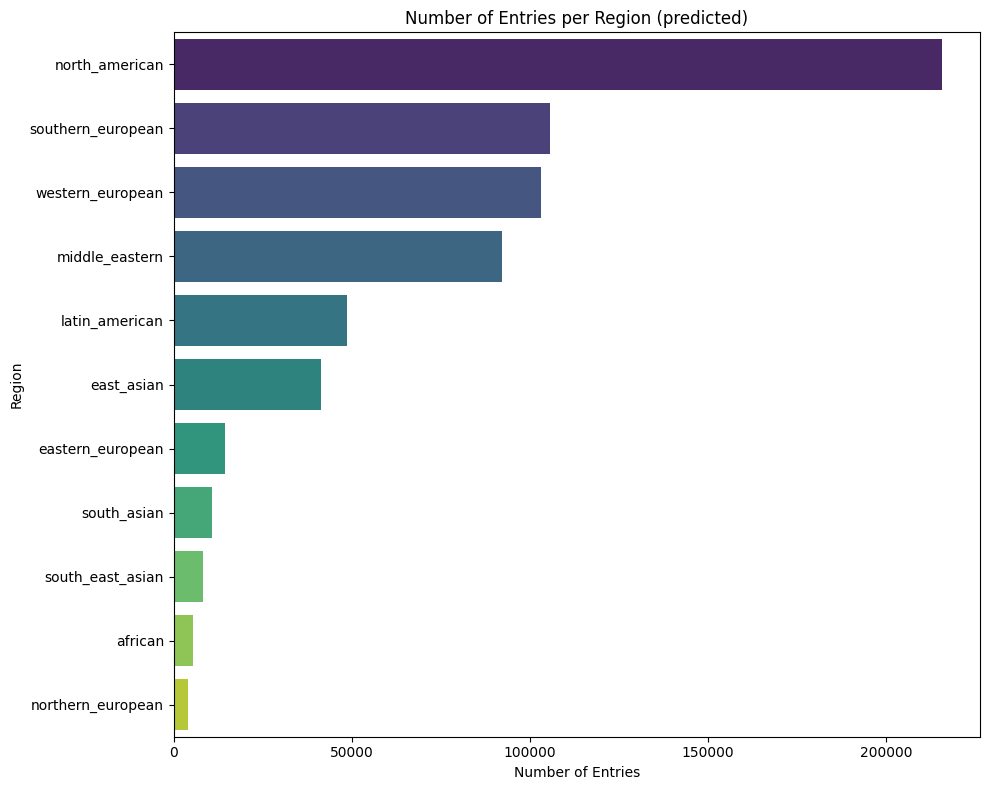

In [24]:
plt.figure(figsize=(10, 8))
sns.barplot(x=predicted_region_counts.values, y=predicted_region_counts.index, palette='viridis')
plt.title('Number of Entries per Region (predicted)')
plt.xlabel('Number of Entries')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

In [ ]:
    # Step 4: Concatenate predictions to super_final_df
print("Concatenating predictions...")
with tqdm(total=1, desc="Step 4") as pbar:
    super_final_df = concat_predictions(source_data, y_pred)
    pbar.update(1)

In [ ]:
mmerged_df = pd.read_csv('data/merged_df_imputed.csv')

# Separate features and target
X = merged_df.drop(columns=['id', 'region'])
y = merged_df['region']

In [ ]:
 # Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score
import joblib

def tune_ensemble_model(X_train, y_train):
    estimators = [
        ('lr', LogisticRegression(max_iter=1000)),
        ('svc', SVC(kernel='linear', probability=True)),
        ('rf', RandomForestClassifier())
    ]

    ensemble = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

    param_grid = {
        'final_estimator__n_estimators': [100, 200],
        'final_estimator__learning_rate': [0.01, 0.1],
        'final_estimator__max_depth': [3, 4, 5],
    }

    grid_search = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_

# Train the tuned model
best_ensemble = tune_ensemble_model(X_train_scaled, y_train)

# Evaluate the tuned model
y_pred = best_ensemble.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f'Tuned Ensemble Model Accuracy: {acc}')

# Print the tuned parameters
print(f'Best parameters found: {best_ensemble}')

In [ ]:
# Train the tuned model
best_ensemble = tune_ensemble_model(X_train_scaled, y_train)

# Evaluate the tuned model
y_pred = best_ensemble.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f'Tuned Ensemble Model Accuracy: {acc}')

# Export the tuned model
joblib.dump(best_ensemble, 'models/tuned_pretrained_ensemble_model.pkl')

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

def feature_engineering(X_train, X_test):
    # Select the top 20 best features
    selector = SelectKBest(score_func=f_classif, k=20)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected

# Apply feature selection
X_train_selected, X_test_selected = feature_engineering(X_train_scaled, X_test_scaled)

# Train and evaluate the model again using selected features
best_ensemble.fit(X_train_selected, y_train)
y_pred = best_ensemble.predict(X_test_selected)
acc = accuracy_score(y_test, y_pred)
print(f'Ensemble Model Accuracy with Feature Selection: {acc}')


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
import joblib
import numpy as np

def cross_validate_ensemble(X, y):
    estimators = [
        ('lr', LogisticRegression(max_iter=1000)),
        ('svc', SVC(kernel='linear', probability=True)),
        ('rf', RandomForestClassifier())
    ]

    ensemble = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

    # Define the cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(ensemble, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the model on the entire dataset
    ensemble.fit(X, y)

    return ensemble, cv_scores

# Assuming final_merged_df is your dataset and the target variable is 'region'
X = final_merged_df.drop(columns=['region'])
y = final_merged_df['region']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validate and train the ensemble model
best_ensemble, cv_scores = cross_validate_ensemble(X_scaled, y)

# Output the cross-validation results
print(f'Cross-validated Accuracy Scores: {cv_scores}')
print(f'Mean Cross-validated Accuracy: {np.mean(cv_scores)}')

# Export the tuned model
joblib.dump(best_ensemble, 'models/tuned_pretrained_ensemble_model_with_cv.pkl')
